## Загрузим нужные библиотеки

In [220]:
#pip install beautifulsoup4
#!pip install lxml

In [221]:
#!pip install pymorphy2            
#!pip install pymorphy2-dicts      
#!pip install DAWG-Python 

In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange  # Tqdm — библиотека для создания индикаторов выполнения

from bs4 import BeautifulSoup
import re

# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

import pymorphy2

# TfidfVectorizer - класс для преобразования текста в частотные векторы слов
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

In [223]:
df = pd.read_csv("./content/train_dataset_train.csv")

In [224]:
df.shape  # Вывод размера

(2000, 5)

In [225]:
df.head(5)   # Вывод первых 5 строк

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3


In [226]:
df.describe(include=[object])   # Вывод описательной статистики набора данных

,Текст Сообщения,Тематика,Ответственное лицо
count,2000,2000,2000
unique,1974,161,75
top,Свалка мусора,Нарушение дорожного покрытия (ямы) на дорогах...,Администрация города Курска
freq,8,155,421


In [227]:
print(df['Категория'].unique(), len(df['Категория'].unique()))   # Вывод уникальных значений целевой переменной (категорий) и их количества

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12] 17


In [228]:
df['Категория'].value_counts()  # Количество объектов каждого класса в размеченном наборе данных

3     954
0     478
16    149
8     139
4     108
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
12      1
Name: Категория, dtype: int64

<AxesSubplot:xlabel='Категория', ylabel='Count'>

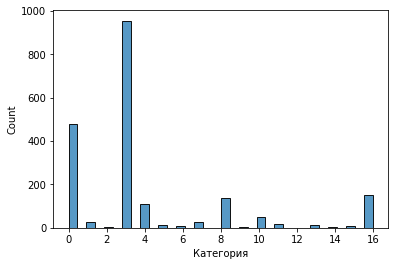

In [229]:
sns.histplot(data=df['Категория'])  # Построение гистограммы, проверка сбалансированности исходного набора данных

In [230]:
df

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3
...,...,...,...,...,...
1995,1356,<p>22.12.21 в вечернее время появилась вонь от...,Неприятные запахи,Комитет природных ресурсов Курской области,16
1996,243,<p>Добрый день! Хочу сообщить о такой проблеме...,Парковки на дорогах в границах городских округ...,Администрация города Курска,0
1997,2350,Состоят 3 засохшие дерева (2 большие берёзы и...,Аварийные деревья,Администрация города Курска,3
1998,1937,"Пожалуйста роман Владимирович, в скором времен...",Нарушение дорожного покрытия (ямы) на дорогах...,Администрация города Курска,0


In [231]:
# Колонку id делаем индексом
data = df.set_index('id') 
#data

In [232]:
# Объединение текстовых колонок в одну
#data["text"] = data['Текст Сообщения'].astype(str) + " " + data['Тематика'].astype(str) + " " + data['Ответственное лицо'].astype(str)
data["text"] = data['Текст Сообщения'].astype(str) 

# Удаление лишних колонок
data = data.drop(columns=['Текст Сообщения', 'Тематика', 'Ответственное лицо'])
data.head()

,Категория,text
id,,
2246,3,Помогите начальник Льговского рэс не реагирует...
380,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...
2240,1,Агресивные собаки. На радуге там стая из подро...
596,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...
1797,3,<p style=`text-align:justify;`><span style=`ba...


In [233]:
# Подсчет соотношения часла строк к число слов в строке
number_of_samples = len(data)
print("Количество строк (объектов)" , number_of_samples)

number_of_words = 0
for index, row in data.iterrows():
    words = row['text'].split()
    number_of_words += len(words)
number_of_words_per_sample = number_of_words / len(data)
print("Количество cлов в строке" , number_of_words_per_sample)

ratio = number_of_samples / number_of_words_per_sample
print("Соотношение: " , ratio)

# Проводим выбор метода машинного обучения (модели) на основе вычисленного показателя

Количество строк (объектов) 2000
Количество cлов в строке 51.445
Соотношение:  38.8764700165225


## Предварительная обработка текста

In [234]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
    return re.sub(r'\s+', ' ', my_string, flags=re.I)

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

# Обработка строк + дополнительно приведение к нижнему регистру
def preproccessing(text):
    s = BeautifulSoup(text, "lxml").text # используем спецбиблиотеку
#    s = cleanhtml(text)
    s = s.lower()
    s = remove_punctuation(s)
    s = remove_numbers(s)
    s = remove_multiple_spaces(s)
    return s

# Создаем колонку в датасете для обработанного текста
data['text_processed'] = list(map(preproccessing, data['text']))
data.head()

C:\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,Категория,text,text_processed
id,,,
2246,3,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...
380,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,по фасаду дома по адресу ул урицкого проходит ...
2240,1,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...
596,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,на пересечении улиц сосновская и береговая зав...
1797,3,<p style=`text-align:justify;`><span style=`ba...,здравствуйте рядом с домом «а» по улице светла...


In [235]:
df.head(3)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1


In [236]:
# Займемся лемматизацией
morph = pymorphy2.MorphAnalyzer()

In [237]:
nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [238]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan', 'г', '“', '”',])

In [239]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(data['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
data['text_lemmed'] = lemm_texts_column

  0%|          | 0/2000 [00:00<?, ?it/s]

In [240]:
#data['text_lemmed'][380]

In [241]:
data['text_lemmed']

id
2246    помочь начальник льговский рэс реагировать жал...
380     фасад дом адрес ул урицкий проходить труба газ...
2240    агресивный собака радуга стая подрасти щенок з...
596     пересечение улица сосновский береговой завалит...
1797    здравствуйте рядом дом улица светлый вне придо...
                              ...                        
1356         вечерний время появиться вонь грибной радуга
243     добрый день хотеть сообщить проблема возле наш...
2350    состоять засохнуть дерево больший берёза один ...
1937    пожалуйста роман владимирович скорый время кур...
1185    сдать пцр тест результат тест портал госуслуга...
Name: text_lemmed, Length: 2000, dtype: object

In [242]:
data.head()

,Категория,text,text_processed,text_lemmed
id,,,,
2246,3,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...,помочь начальник льговский рэс реагировать жал...
380,3,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,по фасаду дома по адресу ул урицкого проходит ...,фасад дом адрес ул урицкий проходить труба газ...
2240,1,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...,агресивный собака радуга стая подрасти щенок з...
596,3,<p>На пересечении &nbsp;улиц Сосновская и Бере...,на пересечении улиц сосновская и береговая зав...,пересечение улица сосновский береговой завалит...
1797,3,<p style=`text-align:justify;`><span style=`ba...,здравствуйте рядом с домом «а» по улице светла...,здравствуйте рядом дом улица светлый вне придо...


In [243]:
# Взвешиваем важность слов и создаем матрицу признаков
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(data['text_lemmed'])
feature_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Финальный датасет

In [244]:
# Матрица признаков
X = data['text_lemmed']

# Вектор значений целевых переменных
y = data['Категория']

labels = data['Категория'].unique() # Массив уникальных меток

In [245]:
# Разбиение на обучающую выборку (70%) и тестовую выборку (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Метод опорных векторов (SVM)

In [246]:
# Загрузка SVM
sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=0, max_iter=10, tol=None)),
               ])

In [247]:
%%time
sgd.fit(X_train, y_train)  # Обучение модели

CPU times: total: 141 ms
Wall time: 158 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=10, random_state=0,
                               tol=None))])

In [248]:
%%time
y_pred = sgd.predict(X_test) # Предсказание на тестовых данных

CPU times: total: 31.2 ms
Wall time: 49 ms


In [249]:
# Оценка точности классификации
print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred, target_names=labels))

accuracy 0.7983333333333333


In [250]:
#from sklearn.externals import joblib
import joblib
joblib.dump(sgd, 'model.pkl')

['model.pkl']

## Готовим тестовый датасет

In [251]:
fittedModel = joblib.load('model.pkl')
#fittedModel.predict(X_new)  # X_new is unseen example to be predicted

In [252]:
tdf = pd.read_csv("./content/test_dataset_test.csv")

In [253]:
#len(tdf)

In [254]:
tdata = tdf.set_index('id') 

In [255]:
tdata["text"] = tdata['Текст Сообщения'].astype(str) 
tdata = tdata.drop(columns=['Текст Сообщения', 'Тематика', 'Ответственное лицо'])
#tdata.head()

In [256]:
tdata['text_processed'] = list(map(preproccessing, tdata['text']))
tdata.head()

C:\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,text,text_processed
id,,
843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,здравствуйте на улице мира было заменено наруж...
1422,<p>Уже вторую неделю не горит уличное освещени...,уже вторую неделю не горит уличное освещение
2782,Не работает освещение во дворе дома 11а по Эне...,не работает освещение во дворе дома а по энерг...
2704,После покоса сорной растительности на газоне м...,после покоса сорной растительности на газоне м...
1,<p>Прошу принять меры к водителю маршрута 263:...,прошу принять меры к водителю маршрута пос сев...


In [257]:
lemm_texts_column = []
for text in tqdm(tdata['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
tdata['text_lemmed'] = lemm_texts_column

  0%|          | 0/1000 [00:00<?, ?it/s]

In [258]:
#tdata['text_lemmed']

In [259]:
X_new = tdata['text_lemmed']

In [260]:
predicts = fittedModel.predict(X_new)

In [261]:
predicts

array([ 3,  3,  3,  3,  8,  8,  3,  3,  3,  4,  4,  3,  3,  3,  3,  0,  8,
        3,  3,  0,  0,  3,  3,  3, 16,  3,  3, 10,  3, 16,  3,  0,  3,  8,
        3,  0,  4,  3,  3, 16,  0,  3,  1,  3,  3,  3,  4,  0,  3,  3,  0,
        8,  3,  3,  0,  3,  3,  1, 16,  0,  3,  3,  3,  3,  3,  3,  3,  3,
        8,  3,  0,  3,  3,  3,  0,  0,  3,  0,  3,  3,  3,  3,  3,  4,  3,
        3,  3,  3,  3, 16,  3, 10,  0,  3,  3,  3,  3,  3,  3, 16,  0,  0,
        3,  0,  3,  3,  3,  3,  3,  3,  0,  0,  0, 16,  0,  8,  0,  3,  3,
        3,  0,  0,  8,  3, 16,  0,  0,  3,  0,  8, 10,  3,  4,  3,  3,  3,
        3,  0,  4,  3,  8,  4,  0,  0,  0,  0,  3,  3,  0,  0,  8,  3,  0,
        0,  3,  3,  0,  3,  0,  0,  3,  3,  3, 10,  3,  8,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  8,  8,  3,  0,  3,  3,  0,  3,  0,  3,  3,
        3,  3,  3,  3,  8,  3,  3, 16,  3,  0,  3,  3,  3,  3,  3,  3, 10,
        3,  1,  8,  0, 16,  3,  8,  8,  1,  3,  4,  3,  3,  0,  0,  8, 16,
        0,  3,  3,  3,  0

In [262]:
len(predicts)

1000

In [263]:
test_names = tdata.index.tolist()
#test_names

In [264]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts.tolist())], columns=['id','Категория'])

In [265]:
submit_df.to_csv("RSF_submit.csv", index=False)